In [2]:
import efinance as ef

In [20]:
#ef.api.stock.config.EASTMONEY_STOCK_BASE_INFO_FIELDS
#ef.api.stock.config.EASTMONEY_STOCK_DAILY_BILL_BOARD_FIELDS
#ef.api.stock.config.HERE
#print(ef.stock.get_members.__doc__)

In [32]:
# get constituents of CSI 300
ef.stock.get_members('000300')

,指数代码,指数名称,股票代码,股票名称,股票权重
0,000300,沪深300,600519,贵州茅台,6.05
1,000300,沪深300,601318,中国平安,2.45
2,000300,沪深300,300750,宁德时代,2.44
3,000300,沪深300,600036,招商银行,1.97
4,000300,沪深300,000858,五粮液,1.52
...,...,...,...,...,...
295,000300,沪深300,601808,中海油服,0.05
296,000300,沪深300,603486,科沃斯,0.05
297,000300,沪深300,000800,一汽解放,0.05
298,000300,沪深300,601059,信达证券,0.04


In [29]:
# get dates of available financial reports
all_filings_dates = ef.stock.get_all_report_dates()

In [30]:
#print(ef.stock.get_all_company_performance.__doc__)
# get data of all stocks for a given fiscal quarter
all_financials_df = ef.stock.get_all_company_performance()
all_financials_df.head()

,股票代码,股票简称,公告日期,营业收入,营业收入同比增长,营业收入季度环比,净利润,净利润同比增长,净利润季度环比,每股收益,每股净资产,净资产收益率,销售毛利率,每股经营现金流量
0,603004,鼎龙科技,2023-12-08 00:00:00,5.255461e+08,-14.553308,NaN,1.211571e+08,27.87,NaN,0.6900,5.523027,13.26,40.976110,0.771125
1,301526,国际复材,2023-12-07 00:00:00,5.282555e+09,-11.658277,-0.7013,4.190942e+08,-56.35,-43.9675,0.1400,2.187620,6.40,22.484612,0.139672
2,601096,宏盛华源,2023-12-05 00:00:00,6.579552e+09,1.577013,NaN,8.899381e+07,-31.15,NaN,0.0444,1.579795,2.86,7.301646,0.254216
3,603373,安邦护卫,2023-12-01 00:00:00,1.746902e+09,4.226754,NaN,7.496986e+07,5.79,NaN,0.9300,14.896104,6.45,24.833696,-0.132578
4,001358,兴欣新材,2023-12-01 00:00:00,5.021528e+08,-12.572165,NaN,1.286955e+08,-26.89,NaN,1.9500,10.494037,20.48,36.084669,1.517174


In [3]:
ef.stock.get_base_info('159941')

股票代码              159941
股票名称               纳指ETF
净利润                    -
总市值       16330471534.08
流通市值      16330471534.08
所处行业                   -
市盈率(动)                 -
市净率                    -
ROE                    -
毛利率                    -
净利率                    -
板块编号                   -
dtype: object

In [35]:
csi1000=ef.stock.get_members('000852')

In [36]:
csi1000_base_info=ef.stock.get_base_info(csi1000['股票代码'].values.tolist())

Processing => 002053: 100%|██████████| 1000/1000 [02:23<00:00,  6.94it/s]


In [37]:
csi1000_base_info.head()

,股票代码,股票名称,净利润,总市值,流通市值,所处行业,市盈率(动),市净率,ROE,毛利率,净利率,板块编号
0,002436,兴森科技,1.904577e+08,2.546154e+10,2.260987e+10,电子元件,100.26,3.83,2.88,25.533829,3.968632,BK0459
1,002456,欧菲光,-2.993583e+08,2.827786e+10,2.811268e+10,光学光电子,-70.85,9.46,-9.61,7.731232,-3.381968,BK1038
2,002405,四维图新,-4.948834e+08,2.280263e+10,2.233185e+10,软件开发,-34.56,2.02,-4.31,42.401634,-23.455312,BK0737
3,300339,润和软件,9.816947e+07,2.220393e+10,2.156478e+10,互联网服务,169.63,6.69,3.01,27.922431,4.414973,BK0447
4,002176,江特电机,-9.557821e+07,2.066360e+10,2.065989e+10,电机,-162.15,5.01,-2.28,7.156249,-3.513946,BK1030


<AxesSubplot:>

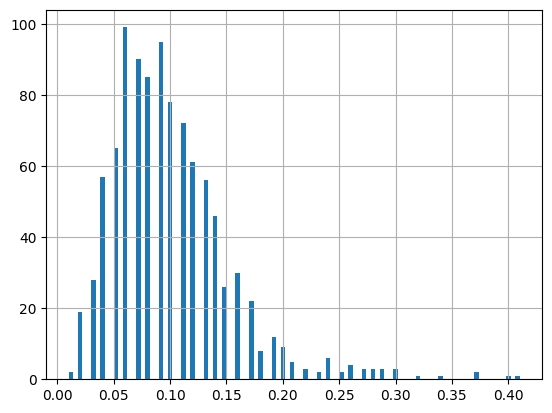

In [40]:
csi1000['股票权重'].hist(bins=100)

In [25]:
#print(ef.stock.get_base_info.__doc__)
# get base info of 000001
ef.stock.get_base_info(['000001','000002'])

Processing => 000002: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


,股票代码,股票名称,净利润,总市值,流通市值,所处行业,市盈率(动),市净率,ROE,毛利率,净利率,板块编号
0,000001,平安银行,3.963500e+10,1.804750e+11,1.804716e+11,银行,3.42,0.46,9.88,0.000000,31.053638,BK0475
1,000002,万 科Ａ,1.362148e+10,1.286130e+11,1.047457e+11,房地产开发,7.08,0.51,5.45,17.580642,7.243104,BK0451
